<a href="https://colab.research.google.com/github/m-a-hasan/ai-colab/blob/main/08_natural_language_processing_with_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-7fb0e58c-e660-bcff-6761-58f27f183cda)


In [ ]:
# Get helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-12-05 01:42:21--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-12-05 01:42:22 (90.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Imports from helper function
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

In [ ]:
# Download and unzip text data
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

unzip_data("nlp_getting_started.zip")

--2022-12-05 01:42:25--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 142.250.4.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.004s  

2022-12-05 01:42:25 (147 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
# Turn csv files into pandas DataFrame
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# Train has a target (1 or 0), test doesn't have it. We will predict it.
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# Check how many 1s and 0s we have in total
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

0 = not a real disaster tweet -> 60% of data
1 = real disaster tweet -> 40% of data

In [ ]:
# How many samples we have
print(f"Total training sample: {len(train_df)}")
print(f"Total testing sample: {len(test_df)}")
print(f"Total sample: {len(train_df) + len(test_df)}")

Total training sample: 7613
Total testing sample: 3263
Total sample: 10876


In [ ]:
# As test data doesn't have target, we'll use 10% train data to validate
from sklearn.model_selection import train_test_split

train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1,
                                                                            random_state=42)

In [ ]:
# Check length
len(train_sentences), len(val_sentences), len(train_labels), len(val_labels)

(6851, 762, 6851, 762)

In [ ]:
# Check first 10 train sentences and their label
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object), array([0, 

There are 2 ways to convert string to number
1. **Tokenization**
- Word level (dog = 1, cat = 2)
- Character level (d = 1, o = 2, g = 3)
- sub-word (fav = 0, our = 1, ite = 3)
2. Embeddings (Representation of a natural language using vector)
- Create own embedding (turn text to number and use tf.keras.layers.Embedding)
- Reuse a pre-learned embedding (already trained on big text like wikipedia)

In [ ]:
# Tokenization
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=None, # how many words in my vocabulary (e.g. 20,000), here we'll say all the words
                                    standardize="lower_and_strip_punctuation", # make all characters lower and get rid of punctuations
                                    split="whitespace", # how to split different words, if there is a whitespace in between
                                    ngrams=None, # how many words per token split
                                    output_mode="int", # what type is the text going to be in
                                    output_sequence_length=None) # lenth of tokenized sequence (e.g. 150)
                                    # pad_to_max_tokens=True) # Only if max_tokens is not None. It'll be padded to whatever max_tokens value is

Common values for max_tokens is increament of 10,000 (e.g. 10,000, 20,000, 30,000) or the exact number of unique words (e.g. 3235)

We will use output_sequence_length as average number of tokens per tweet

In [ ]:
# Find average number of tokens per tweet in training dataset
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Create another TextVectorization using custom parameter
max_vocab_length = 10000 # max number of unique words we have in our vocabulary
max_length = 15 # how many words from a tweet does our model see

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit text_vectorizer in training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Check how tokenizer works
sample_sentence = "there's flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

As our sequence is 15, we got values for our 5 words and next 10 (total 15) are 0

In [ ]:
# Get unique words in the vocabulary
words_in_vocab = text_vectorizer.get_vocabulary()
top_5_words = words_in_vocab[:5]
bottom_5_words = words_in_vocab[-5:]
print(f"Number of words in vocab: {len(words_in_vocab)}") # [UNK] is for unique words
print(f"Top 5 words in vocab: {top_5_words}")
print(f"Bottom 5 words in vocab: {bottom_5_words}")

Number of words in vocab: 10000
Top 5 words in vocab: ['', '[UNK]', 'the', 'a', 'in']
Bottom 5 words in vocab: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
# Create embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=max_vocab_length, # input shape
                             output_dim = 128, # size of embedding vector
                             embeddings_initializer="uniform", # it's the default value. It initializes randomly
                             input_length=max_length,
                             name="embedding_1")

In [ ]:
# Trying this layer in a sample sentence
import random
random_sentence = random.choice(train_sentences)
print(f"Original sentence:\n{random_sentence}\n\nEmbedded version:")

# Embed the text into numerical version
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original sentence:
DK Eyewitness Travel Guide : Chicago by Dorling Kindersley Publishing StaffÛ_: travel books eBay auctions you s... http://t.co/tj3LtPZfW1

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01052564, -0.01399077, -0.03024312, ..., -0.04800494,
         -0.0458707 , -0.0266659 ],
        [ 0.04892547,  0.0187176 ,  0.03868258, ...,  0.03991986,
         -0.01771511,  0.00942028],
        [ 0.01710867,  0.00313964,  0.04880884, ..., -0.01096191,
          0.01881185,  0.02079229],
        ...,
        [ 0.03177475, -0.00860753, -0.03964424, ...,  0.01106938,
          0.01294775,  0.01531184],
        [-0.04054233, -0.01067029,  0.03530501, ...,  0.01670787,
         -0.01496007,  0.02210269],
        [-0.00123378,  0.00323629, -0.0277025 , ..., -0.01858177,
         -0.04566612,  0.04470313]]], dtype=float32)>

**Steps**
1. Construct model
2. Train model
3. Make prediction
4. Track evaluation for comparison later

**Models**
1. Naive Bayes (baseline)
2. Feed-forward neural network (dense model)
3. LSTM model
4. GRU model
5. Bi-directional LSTM model
6. Tensorflow Hub pretrained feature extract
7. Same as last one but with 10% training data

In [ ]:
# Model 0: Baseline model
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
    ("tfidf", TfidfVectorizer()), # convert words to numbers using tfidf
    ("clf", MultinomialNB()) # model the text
])

# Fit pipeline to training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

This is a very shallow model, that is why it is very fast

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

Create an evaluation function for our predictions
- Accuracy
- Precision
- Recall
- F1-score

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculate model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall and f1 score
  """
  # Calculate accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)

baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

Model 1: Simple dense model

In [ ]:
# Build model using functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1 dimensional string
x = text_vectorizer(inputs) # turning text into numbers
x = embedding(x) # create embedding
x = layers.GlobalAveragePooling1D()(x) # lower the dimension of the embedding
outputs = layers.Dense(1, activation="sigmoid")(x) # create output layer, we want binary output so use sigmoid
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
# Compile
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

We created embedding of size 128 (output_dim=128) for a vocabulary of size 10,000. Therefore, 128 * 10,000 = 1,280,000 trainable parameters.

In [ ]:
# Fit model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="simple_dense_model")])

Saving TensorBoard log files to: model_logs/simple_dense_model/20221205-014231
Epoch 1/5
215/215 [==============================] - 6s 9ms/step - loss: 0.6094 - accuracy: 0.6916 - val_loss: 0.5357 - val_accuracy: 0.7572
Epoch 2/5
215/215 [==============================] - 2s 8ms/step - loss: 0.4410 - accuracy: 0.8189 - val_loss: 0.4691 - val_accuracy: 0.7848
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3463 - accuracy: 0.8605 - val_loss: 0.4590 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 7ms/step - loss: 0.2848 - accuracy: 0.8923 - val_loss: 0.4641 - val_accuracy: 0.7927
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.2380 - accuracy: 0.9118 - val_loss: 0.4767 - val_accuracy: 0.7874


In [ ]:
# Results
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4767 - accuracy: 0.7874


[0.4766846001148224, 0.787401556968689]

In [ ]:
embedding.weights

[<tf.Variable 'embedding_1/embeddings:0' shape=(10000, 128) dtype=float32, numpy=
 array([[ 0.00073165,  0.01504798, -0.03425454, ..., -0.0440354 ,
         -0.01042281,  0.01876436],
        [ 0.04135865, -0.03945083, -0.0381194 , ...,  0.00464735,
          0.03163552,  0.029283  ],
        [ 0.00684031,  0.05363131, -0.00241555, ..., -0.07082178,
         -0.04750705,  0.01448254],
        ...,
        [-0.03301444, -0.0052493 , -0.04209725, ...,  0.02028764,
          0.00308807,  0.02215792],
        [ 0.00692343,  0.05942352, -0.01975194, ..., -0.06199061,
         -0.01018393,  0.03510419],
        [-0.03723461,  0.06267188, -0.07451148, ..., -0.02367218,
         -0.0864333 ,  0.01742156]], dtype=float32)>]

In [ ]:
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
# Predict
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10] # only print out the first 10 of prediction probabilities

24/24 [==============================] - 0s 2ms/step


array([[0.40488204],
       [0.7443312 ],
       [0.997895  ],
       [0.10889999],
       [0.11143529],
       [0.93556094],
       [0.91345936],
       [0.9925345 ],
       [0.97156817],
       [0.2657034 ]], dtype=float32)

Sigmoid gives us prediction probabilities. We'll have to use tf.round() to make it binary classification (below 0.5 is 0 and above is 1).

In [ ]:
# Turn probabilities into single-dimension tensor of floats
model_1_preds = tf.squeeze(tf.round(model_1_pred_probs)) # squeeze removes single dimensions without values
model_1_preds[:20]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 1.], dtype=float32)>

In [ ]:
# Calculate model 1 metrics
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1_preds)

model_1_results

{'accuracy': 78.74015748031496,
 'precision': 0.7914920592553047,
 'recall': 0.7874015748031497,
 'f1': 0.7846966492209201}

In [ ]:
# Compare with base model
import numpy as np
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False, False])

In [ ]:
# Create a function to compare better
def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")

In [ ]:
compare_baseline_to_new_results(baseline_results=baseline_results,
                                new_model_results=model_1_results)

baseline accuracy: 79.27, New accuracy: 78.74, Difference: -0.52
baseline precision: 0.81, New precision: 0.79, Difference: -0.02
baseline recall: 0.79, New recall: 0.79, Difference: -0.01
baseline f1: 0.79, New f1: 0.78, Difference: -0.00


Visualizing learned embeddings

In [ ]:
# Check vocabulary from text vectorization
words_in_vocab = text_vectorizer.get_vocabulary()
len(words_in_vocab), words_in_vocab[:10]

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Get weight matrix of embedding layer
embed_weights = model_1.get_layer("embedding_1").get_weights()[0]
print(embed_weights.shape)

(10000, 128)


In [ ]:
# Code below is adapted from: https://www.tensorflow.org/tutorials/text/word_embeddings#retrieve_the_trained_word_embeddings_and_save_them_to_disk
import io

# Create output writers
out_v = io.open("embedding_vectors.tsv", "w", encoding="utf-8")
out_m = io.open("embedding_metadata.tsv", "w", encoding="utf-8")

# Write embedding vectors and words to file
for num, word in enumerate(words_in_vocab):
  if num == 0:
     continue # skip padding token
  vec = embed_weights[num]
  out_m.write(word + "\n") # write words to file
  out_v.write("\t".join([str(x) for x in vec]) + "\n") # write corresponding word vector to file
out_v.close()
out_m.close()

# Download files locally to upload to Embedding Projector
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download("embedding_vectors.tsv")
  files.download("embedding_metadata.tsv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

After the files are downloaded into local machine,
1. Go to http://projector.tensorflow.org/
2. Click on "Load data"
3. Upload those 2 downloaded files
4. Explore
5. We can also share the data by clicking "publish"

What I understood -

Embedding is a way for machine to understand words. They are grouped together in a way that machine will understand them better.

RNN - Recurrent Neural Network (Take into account everything in the past to predict future)
- **One to One:** One input one output, image classification
- **One to Many:** One input many output, image captioning (one image can have multiple captions)
- **Many to One:** Classifying a tweet if it is a disaster or not a disaster
- **Many to Many:** Translating English to Spanish, audio to text

Most popular variants of RNN
- Long short term memory cell (LSTMs)
- Gated recurrent unit (GRU)
- Bi-directional RNN

Resources to understand variants
- https://www.youtube.com/watch?v=SEnXr6v2ifU - explains the background of recurrent neural networks and introduces LSTMs.
- https://karpathy.github.io/2015/05/21/rnn-effectiveness/ by Andrej Karpathy - demonstrates the power of RNN's with examples generating various sequences.
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/ by Chris Olah - an in-depth (and technical) look at the mechanics of the LSTM cell, possibly the most popular RNN building block.

Model 2: LSTM

To make sure we are not reusing pretrained embeddings which can cause data leakage, we will have to create a new embedding. "text_vectorizer" layer can be reused as it doesn't get updated during training.

In [ ]:
# Set random seed and new embedding layer
tf.random.set_seed(42)
from tensorflow.keras import layers
model_2_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_2")

In [ ]:
# Create LSTM model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_2_embedding(x)
print(x.shape)
x = layers.LSTM(64)(x) # return vector for whole sequence
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

(None, 15, 128)
(None, 64)


In [ ]:
# Compile
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [ ]:
# Summary
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_2 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
# Fit model
model_2_history = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "LSTM")])

Saving TensorBoard log files to: model_logs/LSTM/20221205-014255
Epoch 1/5
215/215 [==============================] - 6s 9ms/step - loss: 0.5100 - accuracy: 0.7416 - val_loss: 0.4566 - val_accuracy: 0.7822
Epoch 2/5
215/215 [==============================] - 1s 6ms/step - loss: 0.3176 - accuracy: 0.8717 - val_loss: 0.5138 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 1s 6ms/step - loss: 0.2201 - accuracy: 0.9152 - val_loss: 0.5858 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1556 - accuracy: 0.9428 - val_loss: 0.6041 - val_accuracy: 0.7743
Epoch 5/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1076 - accuracy: 0.9594 - val_loss: 0.8746 - val_accuracy: 0.7507


In [ ]:
# Prediction on validation dataset
model_2_pred_prob = model_2.predict(val_sentences)
model_2_pred_prob.shape, model_2_pred_prob[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1), array([[0.007126  ],
        [0.78736776],
        [0.9996376 ],
        [0.05679169],
        [0.00258219],
        [0.9996238 ],
        [0.9217022 ],
        [0.9997993 ],
        [0.9994954 ],
        [0.66457444]], dtype=float32))

In [ ]:
# Make it 1D array
model_2_preds = tf.squeeze(tf.round(model_2_pred_prob))
model_2_preds.shape, model_2_preds[:10]

(TensorShape([762]),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>)

In [ ]:
# Calculate model_2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)

model_2_results

{'accuracy': 75.06561679790026,
 'precision': 0.7510077975908164,
 'recall': 0.7506561679790026,
 'f1': 0.7489268622514025}

In [ ]:
# Compare with baseline
compare_baseline_to_new_results(baseline_results, model_2_results)

baseline accuracy: 79.27, New accuracy: 75.07, Difference: -4.20
baseline precision: 0.81, New precision: 0.75, Difference: -0.06
baseline recall: 0.79, New recall: 0.75, Difference: -0.04
baseline f1: 0.79, New f1: 0.75, Difference: -0.04


Model 3: GRU

Resources
- https://en.wikipedia.org/wiki/Gated_recurrent_unit - Wikipedia page
- https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be Understanding GRU networks by Simeon Kostadinov

Input(text) -> Tokenize -> Embedding -> GRU -> Dense(output)

In [ ]:
tf.random.set_seed(42)
from tensorflow.keras import layers
model_3_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_3")

# Build RNN using GRU cell
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_3_embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs, outputs, name="model_3_GRU")

In [ ]:
model_3.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [ ]:
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_3 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
model_3_history = model_3.fit(x=train_sentences,
                              y=train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "GRU")])

Saving TensorBoard log files to: model_logs/GRU/20221205-014308
Epoch 1/5
215/215 [==============================] - 4s 8ms/step - loss: 0.5242 - accuracy: 0.7314 - val_loss: 0.4553 - val_accuracy: 0.7769
Epoch 2/5
215/215 [==============================] - 1s 7ms/step - loss: 0.3195 - accuracy: 0.8694 - val_loss: 0.4937 - val_accuracy: 0.7808
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.2197 - accuracy: 0.9181 - val_loss: 0.5607 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 1s 6ms/step - loss: 0.1599 - accuracy: 0.9441 - val_loss: 0.6220 - val_accuracy: 0.7782
Epoch 5/5
215/215 [==============================] - 1s 7ms/step - loss: 0.1221 - accuracy: 0.9584 - val_loss: 0.6205 - val_accuracy: 0.7677


In [ ]:
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs.shape, model_3_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


((762, 1), array([[0.33325252],
        [0.87741184],
        [0.9980252 ],
        [0.11561754],
        [0.01235959],
        [0.9925639 ],
        [0.6214263 ],
        [0.99813336],
        [0.9982377 ],
        [0.5018108 ]], dtype=float32))

In [ ]:
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds.shape, model_3_preds[:10]

(TensorShape([762]),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>)

In [ ]:
# Evaluate on ground truth table
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)

model_3_results

{'accuracy': 76.77165354330708,
 'precision': 0.7675450859410361,
 'recall': 0.7677165354330708,
 'f1': 0.7667932666650168}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_3_results)

baseline accuracy: 79.27, New accuracy: 76.77, Difference: -2.49
baseline precision: 0.81, New precision: 0.77, Difference: -0.04
baseline recall: 0.79, New recall: 0.77, Difference: -0.02
baseline f1: 0.79, New f1: 0.77, Difference: -0.02


Model 4: Bidirectional RNN - Goes over the text from left to right then from right to left

In [ ]:
# Random seed
tf.random.set_seed(42)
from tensorflow.keras import layers

# Create embedding
model_4_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_4")

In [ ]:
# Create bi-directional model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_4_embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x) # layers.GRU(64) would've created bidirectional GRU cell
outputs = layers.Dense(1, activation="sigmoid")(x)

model_4 = tf.keras.Model(inputs, outputs, name="model_4_bidirectional")

In [ ]:
model_4.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [ ]:
model_4.summary()

Model: "model_4_bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_4 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

Because it is bidirectional, it has 1,378,945 trainable parameter compared to LSTM, which has 1,329,473

In [ ]:
model_4_history = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "bidirectional_RNN")])

Saving TensorBoard log files to: model_logs/bidirectional_RNN/20221205-014318
Epoch 1/5
215/215 [==============================] - 6s 12ms/step - loss: 0.5093 - accuracy: 0.7481 - val_loss: 0.4606 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.3135 - accuracy: 0.8708 - val_loss: 0.5144 - val_accuracy: 0.7690
Epoch 3/5
215/215 [==============================] - 2s 10ms/step - loss: 0.2150 - accuracy: 0.9178 - val_loss: 0.5626 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1523 - accuracy: 0.9469 - val_loss: 0.6365 - val_accuracy: 0.7769
Epoch 5/5
215/215 [==============================] - 2s 9ms/step - loss: 0.1083 - accuracy: 0.9639 - val_loss: 0.6509 - val_accuracy: 0.7664


In [ ]:
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs.shape, model_4_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


((762, 1), array([[0.04000048],
        [0.827929  ],
        [0.99842227],
        [0.13531093],
        [0.00311337],
        [0.99220747],
        [0.9552836 ],
        [0.99945647],
        [0.99898285],
        [0.28141674]], dtype=float32))

In [ ]:
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds.shape, model_4_preds[:10]

(TensorShape([762]),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>)

In [ ]:
model_4_results = calculate_results(val_labels, model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'precision': 0.7665895370389821,
 'recall': 0.7664041994750657,
 'f1': 0.7651213533864446}

In [ ]:
compare_baseline_to_new_results(baseline_results, model_4_results)

baseline accuracy: 79.27, New accuracy: 76.64, Difference: -2.62
baseline precision: 0.81, New precision: 0.77, Difference: -0.04
baseline recall: 0.79, New recall: 0.77, Difference: -0.03
baseline f1: 0.79, New f1: 0.77, Difference: -0.02


Model 5: CNN (Conv1D)

In [ ]:
# Testing Conv1D, MaxPooling and Embedding
embedding_test = embedding(text_vectorizer(["This is a test sentence"]))

conv_1d = layers.Conv1D(filters=32,
                        kernel_size=5, # convolve over 5 words at a time
                        activation="relu")
conv_1d_output = conv_1d(embedding_test)

max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # get the most important features

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

We have set input_length = 15 and output_dim = 128 previously for embedding.

In [ ]:
# Create embedding
tf.random.set_seed(42)
from tensorflow.keras import layers

model_5_embedding = layers.Embedding(input_dim=max_vocab_length,
                                     output_dim=128,
                                     embeddings_initializer="uniform",
                                     input_length=max_length,
                                     name="embedding_5")

In [ ]:
from warnings import filters
# Create model
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = model_5_embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs, outputs, name="model_5_Conv1D")

In [ ]:
# Compile
model_5.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [ ]:
model_5.summary()

Model: "model_5_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_5 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d_1 (Glo  (None, 32)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)              

In [ ]:
# Fit
model_5_history = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "Conv1D")])

Saving TensorBoard log files to: model_logs/Conv1D/20221205-014345
Epoch 1/5
215/215 [==============================] - 3s 6ms/step - loss: 0.5652 - accuracy: 0.7141 - val_loss: 0.4733 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 1s 5ms/step - loss: 0.3380 - accuracy: 0.8615 - val_loss: 0.4758 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 1s 5ms/step - loss: 0.2070 - accuracy: 0.9234 - val_loss: 0.5457 - val_accuracy: 0.7730
Epoch 4/5
215/215 [==============================] - 1s 5ms/step - loss: 0.1314 - accuracy: 0.9578 - val_loss: 0.6163 - val_accuracy: 0.7730
Epoch 5/5
215/215 [==============================] - 2s 8ms/step - loss: 0.0933 - accuracy: 0.9691 - val_loss: 0.6779 - val_accuracy: 0.7782


In [ ]:
# Predict
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.22534487],
       [0.7534112 ],
       [0.9995602 ],
       [0.05562789],
       [0.01449847],
       [0.9858518 ],
       [0.98418933],
       [0.99758804],
       [0.99862623],
       [0.26914388]], dtype=float32)

In [ ]:
# Round and squeeze
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate
model_5_results = calculate_results(val_labels, model_5_preds)
model_5_results

{'accuracy': 77.82152230971128,
 'precision': 0.7807522349051432,
 'recall': 0.7782152230971129,
 'f1': 0.7758810170952618}

In [ ]:
# Compare
compare_baseline_to_new_results(baseline_results, model_5_results)

baseline accuracy: 79.27, New accuracy: 77.82, Difference: -1.44
baseline precision: 0.81, New precision: 0.78, Difference: -0.03
baseline recall: 0.79, New recall: 0.78, Difference: -0.01
baseline f1: 0.79, New f1: 0.78, Difference: -0.01


Model 6: Pretrained embedding (transfer learning for NLP)

**Difference between our embedding and Universal Sentence Encoder**
- Our embedding is word level embedding, USE is a sentence level embedding
- Our output is 128 dimensional vector, USE is 512 dimensional vector

**Encoder** - Takes some raw data (image, sentences) and converts them into tensors

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
sample_embed = embed(["This is a sample sentence", "When you call a universal sentence embed, it turns a sentence into tensors"])
sample_embed.shape, sample_embed

(TensorShape([2, 512]), <tf.Tensor: shape=(2, 512), dtype=float32, numpy=
 array([[ 0.02977698, -0.00973895,  0.00557957, ..., -0.05354577,
         -0.02809462,  0.03143068],
        [ 0.06342966, -0.0237119 , -0.00899024, ...,  0.07587291,
          0.01807733,  0.02858382]], dtype=float32)>)

In [ ]:
# Create USE embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        input_shape=[],
                                        dtype=tf.string,
                                        name="USE")

In [ ]:
# Create sequential model with embedding layer
model_6 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
], name="model_6_USE")

In [ ]:
# Compile
model_6.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [ ]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit
model_6.fit(train_sentences,
            train_labels,
            epochs=5,
            validation_data=(val_sentences, val_labels),
            callbacks=[create_tensorboard_callback(SAVE_DIR, "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20221205-014452
Epoch 1/5
215/215 [==============================] - 5s 14ms/step - loss: 0.5008 - accuracy: 0.7892 - val_loss: 0.4478 - val_accuracy: 0.7966
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.4144 - accuracy: 0.8133 - val_loss: 0.4369 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3998 - accuracy: 0.8212 - val_loss: 0.4329 - val_accuracy: 0.8110
Epoch 4/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3925 - accuracy: 0.8266 - val_loss: 0.4288 - val_accuracy: 0.8110
Epoch 5/5
215/215 [==============================] - 2s 12ms/step - loss: 0.3860 - accuracy: 0.8276 - val_loss: 0.4309 - val_accuracy: 0.8123


In [ ]:
# Predict
model_6_pred_probs = model_6.predict(val_sentences)
val_sentences[:5], val_labels[:5], model_6_pred_probs.shape, model_6_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


(array(['DFR EP016 Monthly Meltdown - On Dnbheaven 2015.08.06 http://t.co/EjKRf8N8A8 #Drum and Bass #heavy #nasty http://t.co/SPHWE6wFI5',
        'FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday',
        'Gunmen kill four in El Salvador bus attack: Suspected Salvadoran gang members killed four people and wounded s... http://t.co/CNtwB6ScZj',
        '@camilacabello97 Internally and externally screaming',
        'Radiation emergency #preparedness starts with knowing to: get inside stay inside and stay tuned http://t.co/RFFPqBAz2F via @CDCgov'],
       dtype=object), array([0, 0, 1, 1, 1]), (762, 1), array([[0.14443196],
        [0.7271505 ],
        [0.9856655 ],
        [0.19740927],
        [0.73417026],
        [0.68596625],
        [0.9808888 ],
        [0.97411025],
        [0.9157322 ],
        [0.08070082]], dtype=float32))

In [ ]:
# Round the results
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Evaluate
model_6_results = calculate_results(val_labels, model_6_preds)
model_6_results

{'accuracy': 81.23359580052494,
 'precision': 0.8148798668657973,
 'recall': 0.8123359580052494,
 'f1': 0.810686575717776}

In [ ]:
# Compare
compare_baseline_to_new_results(baseline_results, model_6_results)

baseline accuracy: 79.27, New accuracy: 81.23, Difference: 1.97
baseline precision: 0.81, New precision: 0.81, Difference: 0.00
baseline recall: 0.79, New recall: 0.81, Difference: 0.02
baseline f1: 0.79, New f1: 0.81, Difference: 0.02


Model 7: Pretrained model encoder with 10% data

In [ ]:
# Split data to get 10% train data
train_sentences_90_percent, train_sentences_10_percent, train_labels_90_percent, train_labels_10_percent = train_test_split(np.array(train_sentences),
                                                                                                                            train_labels,
                                                                                                                            test_size=0.1,
                                                                                                                            random_state=42)

In [ ]:
print(f"total train sentences: {len(train_sentences)}")
print(f"train sentences 90 percent: {len(train_sentences_90_percent)}")
print(f"train sentences 10 percent: {len(train_sentences_10_percent)}")

total train sentences: 6851
train sentences 90 percent: 6165
train sentences 10 percent: 686


In [ ]:
# We chose random 10 percent so 1 & 0 should be proportional
pd.Series(train_labels_10_percent).value_counts()

0    415
1    271
dtype: int64

We will clone model 6. This will keep the architecture but reset the weight (except the pretrained weight)

In [ ]:
# Clone
model_7 = tf.keras.models.clone_model(model_6)

In [ ]:
# Compile
model_7.compile(optimizer=tf.keras.optimizers.Adam(),
                loss="binary_crossentropy",
                metrics=["accuracy"])

In [ ]:
# Summary
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit
model_7_history = model_7.fit(x=train_sentences_10_percent,
                              y=train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR, "10_percent_tf_hub_pretrained_embedding")])

Saving TensorBoard log files to: model_logs/10_percent_tf_hub_pretrained_embedding/20221205-014519
Epoch 1/5
22/22 [==============================] - 3s 43ms/step - loss: 0.6716 - accuracy: 0.6574 - val_loss: 0.6526 - val_accuracy: 0.6903
Epoch 2/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5972 - accuracy: 0.8032 - val_loss: 0.5944 - val_accuracy: 0.7362
Epoch 3/5
22/22 [==============================] - 1s 26ms/step - loss: 0.5178 - accuracy: 0.8149 - val_loss: 0.5398 - val_accuracy: 0.7625
Epoch 4/5
22/22 [==============================] - 1s 27ms/step - loss: 0.4526 - accuracy: 0.8265 - val_loss: 0.5084 - val_accuracy: 0.7677
Epoch 5/5
22/22 [==============================] - 0s 23ms/step - loss: 0.4094 - accuracy: 0.8382 - val_loss: 0.4915 - val_accuracy: 0.7703


In [ ]:
# Predict
model_7_pred_probs = model_7.predict(val_sentences)
model_7_pred_probs.shape, model_7_pred_probs[:10]

24/24 [==============================] - 1s 9ms/step


((762, 1), array([[0.24043238],
        [0.7683785 ],
        [0.90137184],
        [0.29067948],
        [0.57149994],
        [0.83565134],
        [0.8062943 ],
        [0.83358175],
        [0.8554568 ],
        [0.11749922]], dtype=float32))

In [ ]:
# Round
model_7_preds = tf.squeeze(tf.round(model_7_pred_probs))
model_7_preds.shape, model_7_preds[:10]

(TensorShape([762]),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>)

In [ ]:
# Result
model_7_results = calculate_results(val_labels, model_7_preds)
model_7_results

{'accuracy': 77.03412073490814,
 'precision': 0.7755630249535594,
 'recall': 0.7703412073490814,
 'f1': 0.7667059443150692}

In [ ]:
# Compare
compare_baseline_to_new_results(baseline_results, model_7_results)

baseline accuracy: 79.27, New accuracy: 77.03, Difference: -2.23
baseline precision: 0.81, New precision: 0.78, Difference: -0.04
baseline recall: 0.79, New recall: 0.77, Difference: -0.02
baseline f1: 0.79, New f1: 0.77, Difference: -0.02


Visualize how each results stack up against each other

In [ ]:
# Create pandas dataframe
all_model_results = pd.DataFrame({
    "Baseline result" : baseline_results,
    "Simple dense" : model_1_results,
    "LSTM" : model_2_results,
    "GRU" : model_3_results,
    "Bidirectional" : model_4_results,
    "Conv1D" : model_5_results,
    "Hub sentence encoder" : model_6_results,
    "Hub sentence encoder 10 percent data" : model_7_results
})

all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
Baseline result,79.265092,0.811139,0.792651,0.786219
Simple dense,78.740157,0.791492,0.787402,0.784697
LSTM,75.065617,0.751008,0.750656,0.748927
GRU,76.771654,0.767545,0.767717,0.766793
Bidirectional,76.640420,0.766590,0.766404,0.765121
Conv1D,77.821522,0.780752,0.778215,0.775881
Hub sentence encoder,81.233596,0.814880,0.812336,0.810687
Hub sentence encoder 10 percent data,77.034121,0.775563,0.770341,0.766706


In [ ]:
# Reduce accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
Baseline result,0.792651,0.811139,0.792651,0.786219
Simple dense,0.787402,0.791492,0.787402,0.784697
LSTM,0.750656,0.751008,0.750656,0.748927
GRU,0.767717,0.767545,0.767717,0.766793
Bidirectional,0.766404,0.766590,0.766404,0.765121
Conv1D,0.778215,0.780752,0.778215,0.775881
Hub sentence encoder,0.812336,0.814880,0.812336,0.810687
Hub sentence encoder 10 percent data,0.770341,0.775563,0.770341,0.766706


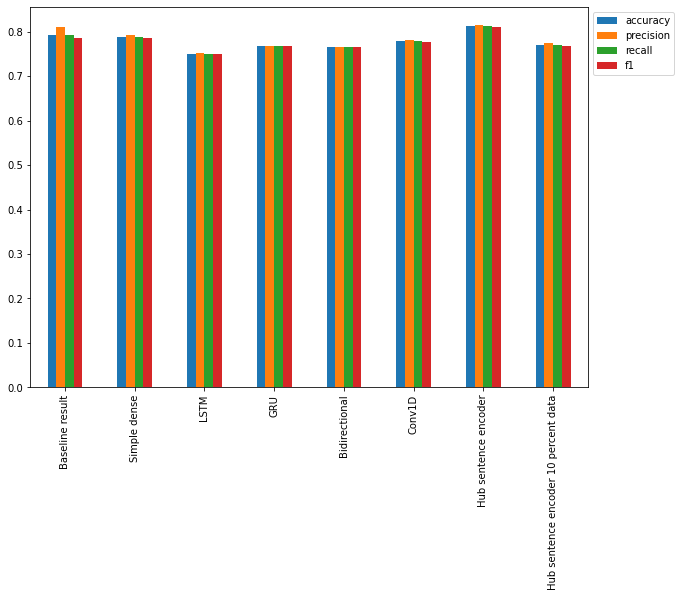

In [ ]:
# Plot
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0))

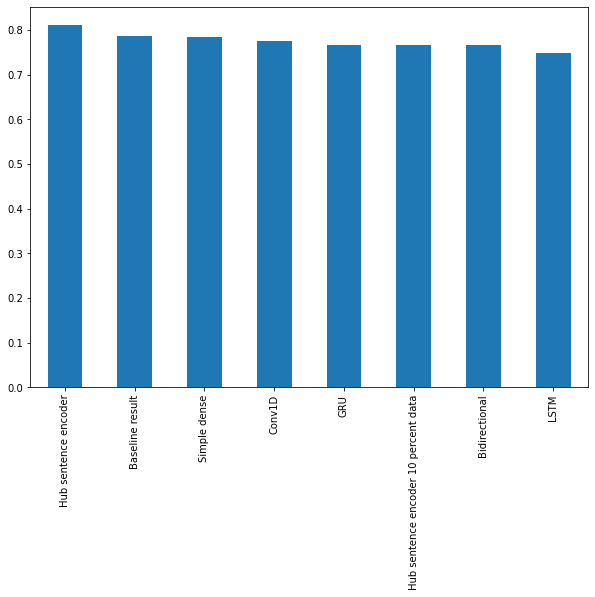

In [ ]:
# Check just by f1 score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7))

If we want to check tensorboard dev

In [ ]:
# # View tensorboard logs of transfer learning modelling experiments (should be 4 models)
# # Upload TensorBoard dev records
# !tensorboard dev upload --logdir ./model_logs \
#   --name "NLP modelling experiments" \
#   --description "A series of different NLP modellings experiments with various models" \
#   --one_shot # exits the uploader when upload has finished

We can delete the experiment from tensorboard using below code

In [ ]:
# If you need to remove previous experiments, you can do so using the following command
# !tensorboard dev delete --experiment_id EXPERIMENT_ID_TO_DELETE

Combining/Ensambling/Stacking models
- **Averaging** - Take the output of prediction of each model for each sample and average them
- **Majority** - Pick the number majority of the model agreed on
- **Stacking** - Take the output of each of the model, use those outputs as input for another model

In [ ]:
# Get baseline model probability
baseline_pred_probs = np.max(model_0.predict_proba(val_sentences), axis=1)
baseline_pred_probs.shape, baseline_pred_probs[:10]

((762,), array([0.55507546, 0.70165655, 0.86646023, 0.78011348, 0.63190603,
        0.8216631 , 0.5759222 , 0.90335826, 0.73121414, 0.82175747]))

**We will combine**
- base_model = model_0
- LSTM = model_2
- USE = model_6

In [ ]:
combined_pred_probs = baseline_pred_probs + tf.squeeze(model_2_pred_prob, axis=1) + tf.squeeze(model_6_pred_probs)
combined_preds = tf.round(combined_pred_probs/3)
combined_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate result
ensemble_results = calculate_results(val_labels, combined_preds)
ensemble_results

{'accuracy': 78.08398950131233,
 'precision': 0.7805216999297674,
 'recall': 0.7808398950131233,
 'f1': 0.7805169025578647}

In [ ]:
# Add ensemble results to the dataframe
all_model_results.loc["ensemble_results"] = ensemble_results
# Convert ensemble result accuracy between 0 to 1
all_model_results.loc["ensemble_results"]["accuracy"] = all_model_results.loc["ensemble_results"]["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
Baseline result,0.792651,0.811139,0.792651,0.786219
Simple dense,0.787402,0.791492,0.787402,0.784697
LSTM,0.750656,0.751008,0.750656,0.748927
GRU,0.767717,0.767545,0.767717,0.766793
Bidirectional,0.766404,0.766590,0.766404,0.765121
Conv1D,0.778215,0.780752,0.778215,0.775881
Hub sentence encoder,0.812336,0.814880,0.812336,0.810687
Hub sentence encoder 10 percent data,0.770341,0.775563,0.770341,0.766706
ensemble_results,0.780840,0.780522,0.780840,0.780517


As most of our results were pretty similar from get go, stacking didn't change the results much

Save model so we can use it in the future in our web application
- **HDF5 format**: This is better for general use out of TensorFlow. But we will need to mention any custom object while loading (e.g. keras hub layer).
- **SaveModel format** - Generally used in TensorFlow. No need to mention custom objects during loading.

In [ ]:
# Save in HDF5
model_6.save("model_6.h5")

In [ ]:
# Loading with custom hub layer
loaded_model_6 = tf.keras.models.load_model("model_6.h5",
                                            custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
loaded_model_6.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4309 - accuracy: 0.8123


[0.43088313937187195, 0.8123359680175781]

In [ ]:
# Saving using SaveModel
model_6.save("model_6_SaveModel")

In [ ]:
# Loading model (mentioning custom object isn't required)
loaded_model_6_savemodel = tf.keras.models.load_model("model_6_SaveModel")

In [ ]:
loaded_model_6_savemodel.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4309 - accuracy: 0.8123


[0.43088313937187195, 0.8123359680175781]

If most of the model are returning the same result, it's time to inspect data. Best way to do that is find most wrong predictions. That is, where prediction gave a high probability and was wrong on that prediction.

In [ ]:
# model_6 had the best result, so let's find most wrong for model_6
val_df = pd.DataFrame({
    "Text": val_sentences,
    "Target": val_labels,
    "Prediction": model_6_preds,
    "Probability": tf.squeeze(model_6_pred_probs)
})

val_df.head()

,Text,Target,Prediction,Probability
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.144432
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.727150
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.985666
3,@camilacabello97 Internally and externally scr...,1,0.0,0.197409
4,Radiation emergency #preparedness starts with ...,1,1.0,0.734170


In [ ]:
most_wrong = val_df[val_df['Target'] != val_df["Prediction"]].sort_values("Probability", ascending=False)
# First 10 rows of false positive (model predicted 1, but it is 0)
most_wrong.head(10)

,Text,Target,Prediction,Probability
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910481
759,FedEx will no longer transport bioterror patho...,0,1.0,0.864676
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.837961
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.836361
628,@noah_anyname That's where the concentration c...,0,1.0,0.835225
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.834875
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.800890
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.782611
698,åÈMGN-AFRICAå¨ pin:263789F4 åÈ Correction: Ten...,0,1.0,0.782433
144,The Sound of Arson,0,1.0,0.771343


In [ ]:
# False negatives (predicted 0 but actually is 1)
most_wrong.tail(10).sort_values("Probability", ascending=True)

,Text,Target,Prediction,Probability
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.032888
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.036272
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038593
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.039261
233,I get to smoke my shit in peace,1,0.0,0.041451
59,You can never escape me. Bullets don't harm me...,1,0.0,0.045356
408,@willienelson We need help! Horses will die!Pl...,1,0.0,0.057318
486,VICTORINOX SWISS ARMY DATE WOMEN'S RUBBER MOP ...,1,0.0,0.060608
221,going to redo my nails and watch behind the sc...,1,0.0,0.062795
40,@BoyInAHorsemask its a panda trapped in a dogs...,1,0.0,0.063043


In [ ]:
# Predicting on test samples (there are no label for this dataset)
test_sentences = test_df["text"].to_list()
test_samples = random.sample(test_sentences, 10)
for test_sample in test_samples:
  pred_prob = tf.squeeze(model_6.predict([test_sample], verbose=0)) # has to be a list. predict(test_sample) won't work
  pred = tf.round(pred_prob)

  print(f"Prediction: {int(pred)}")
  print(f"Probability: {pred_prob}")
  print(f"Text: {test_sample}")
  print(f"------------------")

Prediction: 0
Probability: 0.07548239827156067
Text: Created save #666 on my current Fallout 3 playthrough. Hail Satan!
------------------
Prediction: 0
Probability: 0.06555402278900146
Text: Just cruisingblazing and banging ?
------------------
Prediction: 0
Probability: 0.3904118239879608
Text: Swansea ?plot hijack transfer move for Southampton target Virgil van Dijk? http://t.co/DNZjWwTAkI
------------------
Prediction: 1
Probability: 0.5107115507125854
Text: #yyctraffic #yycstorm  Caller says 'idiots' are stopping under overpasses and blocking 'all lanes on Crowchild' in (small-sized) hailstorm.
------------------
Prediction: 0
Probability: 0.21224430203437805
Text: @deray @marstu67 Cop Benefits:Great Salary Free Car Free Rent Free Food.Free Weapons License to Kill &amp; Rape with Impunity.
------------------
Prediction: 0
Probability: 0.047483619302511215
Text: @Team_Barrowman Just saying your my man crush!
------------------
Prediction: 1
Probability: 0.9567629098892212
Text: Exp

In [ ]:
# Predict any sentence based on model given
my_tweet = "The most important feature in life is the ability to listen to others before coming to a conclusion."

In [ ]:
# Create function to predict
def predict_on_sentence(model, sentence):
  """
  Use to predict if a sentence is talking about disaster or not.
  inputs:
  model = the model to use for prediction
  sentence = tweet
  """
  pred_prob = tf.squeeze(model.predict([sentence], verbose=0)) # has to be a list <model_6.predict(sentence)> won't work.
  pred = "Not a disaster" if int(tf.round(pred_prob)) == 0 else "Disaster"
  print(f"Tweet: {sentence}")
  print(f"Prediction: {pred}")
  print(f"Prediction Probability: {pred_prob}")


In [ ]:
# Test the function
predict_on_sentence(model=model_6,
                    sentence=my_tweet)

Tweet: The most important feature in life is the ability to listen to others before coming to a conclusion.
Prediction: Not a disaster
Prediction Probability: 0.053240757435560226


In [ ]:
# Test with actual disaster
# Source - https://twitter.com/BeirutCityGuide/status/1290696551376007168
beirut_tweet_1 = "Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon"

# Source - https://twitter.com/BeirutCityGuide/status/1290773498743476224
beirut_tweet_2 = "#Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon"

In [ ]:
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_1)

Tweet: Reports that the smoke in Beirut sky contains nitric acid, which is toxic. Please share and refrain from stepping outside unless urgent. #Lebanon
Prediction: Disaster
Prediction Probability: 0.9625465869903564


In [ ]:
predict_on_sentence(model=model_6,
                    sentence=beirut_tweet_2)

Tweet: #Beirut declared a “devastated city”, two-week state of emergency officially declared. #Lebanon
Prediction: Disaster
Prediction Probability: 0.9678557515144348


Speed/Score tradeoff - In production we need to see the speed and accuracy to chose which model to deploy

In [ ]:
import time
# Function to calculate time taken to predict
def pred_timer(model, sample):
  """
  This function calculates how long it takes
  for a model to predict/speed of prediction

  Args:
  -----
  model: model to evaluate the speed of
  sample: sentences(tweets) to predict

  Returns:
  -----
  total_time: time taken to predict the sample
  time_per_sentence: time taken to predict each sentence
  """
  start_time = time.perf_counter()
  model.predict(sample)
  end_time = time.perf_counter()

  total_time = end_time - start_time
  time_per_sentence = total_time/len(sample)

  return total_time, time_per_sentence

In [ ]:
# How long model_6 takes
model_6_total_time, model_6_time_per_pred = pred_timer(model_6, val_sentences)
model_6_total_time, model_6_time_per_pred

24/24 [==============================] - 0s 10ms/step


(0.3514544409999871, 0.00046122630052491747)

In [ ]:
# How long base model (Naive Bayes) take
model_0_total_time, model_0_time_per_pred = pred_timer(model_0, val_sentences)
model_0_total_time, model_0_time_per_pred

(0.021142995999980485, 2.7746713910735546e-05)

Text(0, 0.5, 'F1')

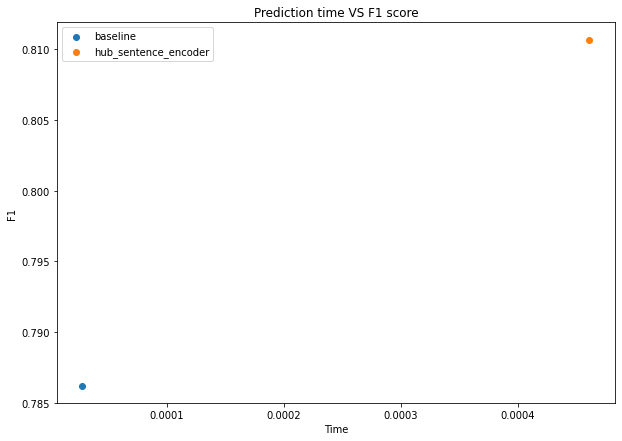

In [ ]:
# Compare in a chart
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(model_0_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_results["f1"], label="hub_sentence_encoder")
plt.legend()

plt.title("Prediction time VS F1 score")
plt.xlabel("Time")
plt.ylabel("F1")